### 1. Baseline with Linear SVM (english translated)

Data loading and cleaning

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [50]:
data = pd.read_csv('../datasets/english1970_data.csv')

In [51]:
data.head()

,comment_eng,sarc_majority
0,more people will bear it appears,sarc
1,have you greed of money people want to do big ...,non-sarc
2,radio television lid do not hear the promise o...,sarc
3,yes you're whipping people is a great budget f...,non-sarc
4,ooi government national front you people aware...,non-sarc


In [52]:
data['sarc_majority'] = data['sarc_majority'].apply(lambda x: 1 if x=='sarc' else 0)

In [53]:
data = data.loc[:, ['comment_eng', 'sarc_majority']]

In [54]:
data.head()

,comment_eng,sarc_majority
0,more people will bear it appears,1
1,have you greed of money people want to do big ...,0
2,radio television lid do not hear the promise o...,1
3,yes you're whipping people is a great budget f...,0
4,ooi government national front you people aware...,0


Machine Learning Model

In [55]:
train, test = train_test_split(data, test_size=0.2, random_state=1)
X_train = train['comment_eng'].values
X_test = test['comment_eng'].values
y_train = train['sarc_majority']
y_test = test['sarc_majority']

In [56]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [57]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [58]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.7s finished


0.7047700568049178

In [59]:
grid_svm.best_params_

{'svc__C': 0.1}

In [60]:
grid_svm.best_score_

0.7498411019767202

In [61]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [62]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.7047700568049178,
 'f1': 0.5775075987841946,
 'acc': 0.6472081218274112,
 'precision': 0.6418918918918919,
 'recall': 0.5248618784530387}

In [63]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [64]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

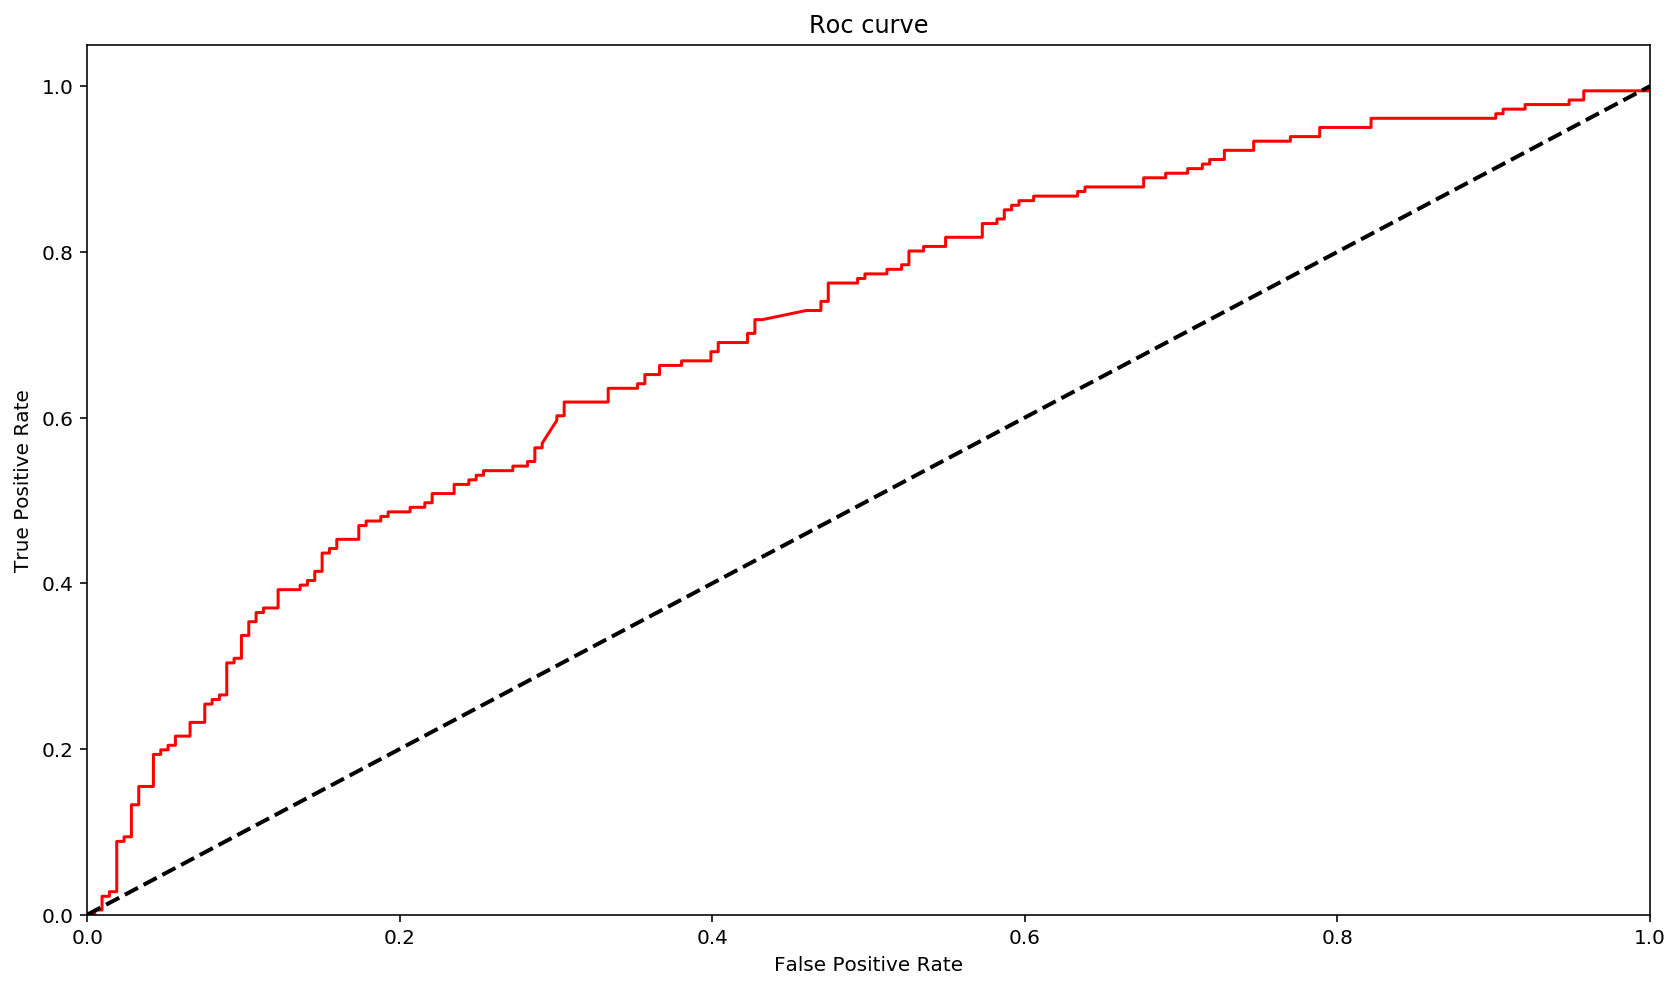

In [65]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [66]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [67]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

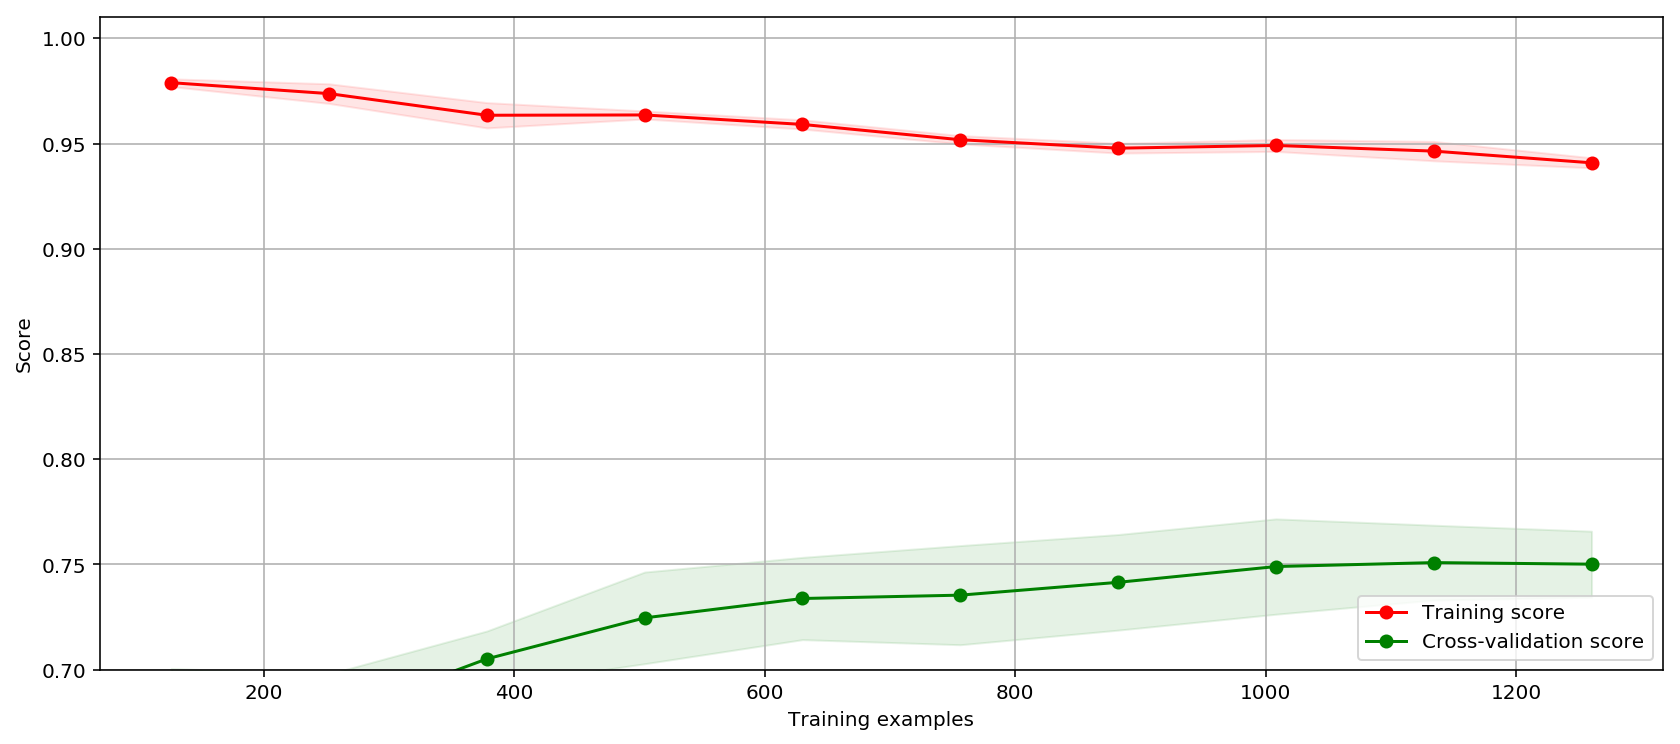

In [68]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

Test examples

Apply the obtained machine learning model to some example text. If the output is **1** it means that the text has a sarcasm associated:

In [69]:
grid_svm.predict(["yess i like it"])

array([0], dtype=int64)

In [70]:
grid_svm.predict(["more people will bear it appears"])

array([0], dtype=int64)

In [71]:
grid_svm.predict(["yes you're whipping people is a great budget"])

array([1], dtype=int64)

In [72]:
grid_svm.predict(["@united very bad experience!"])

array([0], dtype=int64)

In [73]:
grid_svm.predict(["your mother is green!"])

array([0], dtype=int64)